Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

---

## Lab 7: Resampling

Welcome to the seventh lab of the semester!

In this notebook, we'll explore resampling (which is relevant to Homework 7). Resampling is just what it sounds like - it involves repeatedly taking different samples of the data to train and test your model. We'll focus on cross-validation.

### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore', FutureWarning) # Seaborn triggers warnings in scipy
%matplotlib inline

In [3]:
# Configure nice plotting defaults - (this must be done in a cell separate from %matplotlib call)
plt.style.use('seaborn-v0_8')
sns.set_context('talk', font_scale=1)
plt.rcParams['figure.figsize'] = (10, 6)

----

## Creating Testing and Training Splits

To gain a little more intuition about cross-validation, we're going to work with the Boston Housing dataset, which concerns the housing values in the suburbs of Boston. We'll be using two features: `NOX`, the nitrogen oxides concentrations (in ppm) and `LSTAT`, the lower status of the population to predict the `target` column, the median value of owner-occupied homes (in thousands of dollars). Run the following cells to load the data and plot the two features we'll be working with. 

In [4]:
cv_data = pd.read_csv('data/boston_housing.csv')
cv_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


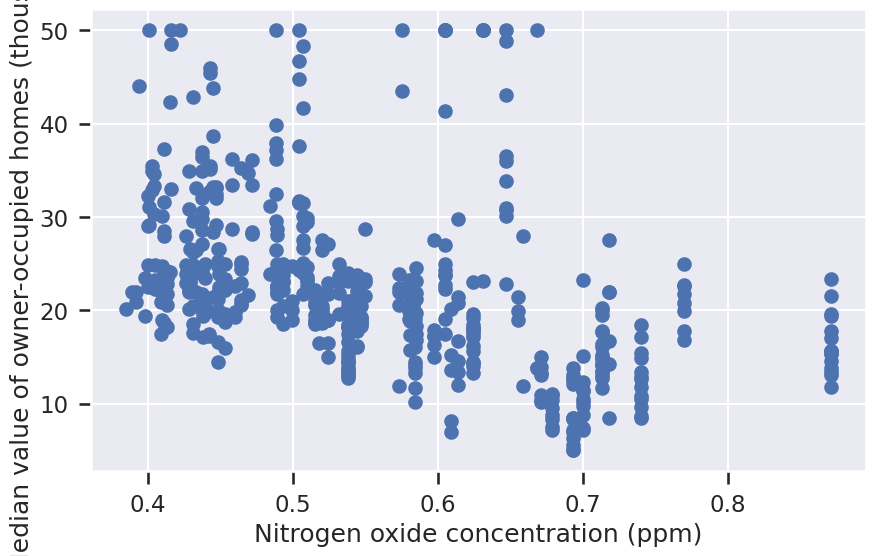

In [5]:
plt.scatter(cv_data.NOX, cv_data.target)
plt.xlabel('Nitrogen oxide concentration (ppm)')
plt.ylabel('Median value of owner-occupied homes (thousand $)');

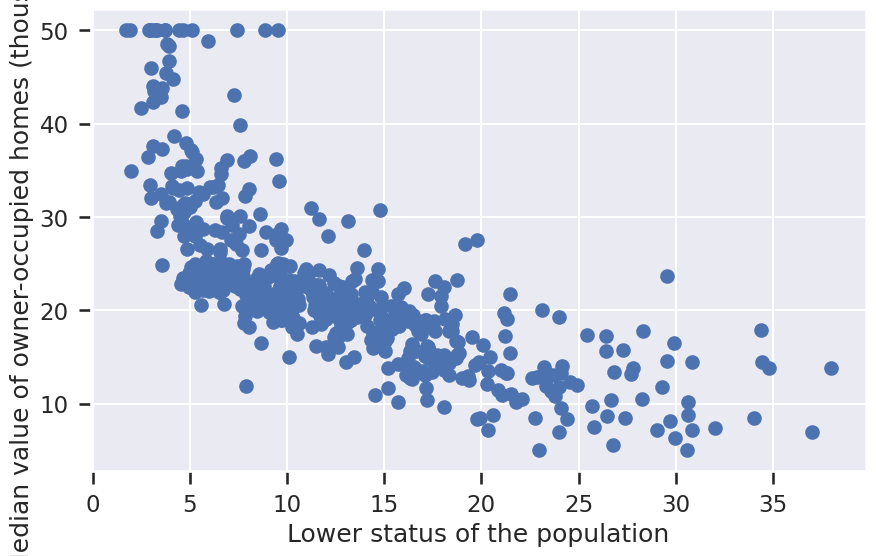

In [6]:
plt.scatter(cv_data.LSTAT, cv_data.target)
plt.xlabel('Lower status of the population')
plt.ylabel('Median value of owner-occupied homes (thousand $)');

Before we attempt cross validation, we're going to split our data into training and testing sets and fit a model to which we can compare our cross validation results. 

**Question 1 (1pt)**  

Split the dataset, using `NOX` and `LSTAT` as our features and `target` as the dependent variable we're predicting. Set `test_size` to 25% of the sample and `random_state` to 2. Here, we'll use the [train_test_split() function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [7]:
from sklearn.model_selection import train_test_split
    
X = ... #specify the features
y = ... #specify the target variable

X_train, X_test, y_train, y_test = train_test_split(...)

TypeError: Singleton array array(Ellipsis, dtype=object) cannot be considered a valid collection.

In [8]:
# SOLUTION 
from sklearn.model_selection import train_test_split
    
X = cv_data[['NOX', 'LSTAT']]
y = cv_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=2)

In [9]:
assert np.isclose(len(X_train), 0.75* len(cv_data), atol=1)
assert np.isclose(len(y_test), 0.25*len(cv_data), atol=1)

Before we continue, let's review the arguments for `train_test_split`.

**Question 2 (1pt)** How do the parameters `test_size` and `random_state` affect the data we work with? How would a higher or lower value for `test_size` affect our results?

*Your answer here*

*SOLUTION*
* `test_size` determines the percent of the data to be withheld in the test dataset. Higher values mean that a lot of data will be withheld, and less data is available for training
* `random_state` sets a random seed so that we can reproduce our results. Higher or lower values do not matter, you can pick any number to set the random state. 

Now, let's fit the model with our training data.

**Question 3 (2pts)** Instantiate a `LinearRegression` model and fit the training data. Then, predict the `target` variable using the testing data. Lastly, print the $R^2$ score as well as the MSE of the fitted model. Here, we're using two new sklearn functions: [r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and [mean_squared_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lm = ...
lm.fit(...)
predictions = 

print('R^2: ', r2_score(...))
print('MSE: ', mean_squared_error(...))

SyntaxError: invalid syntax (71850171.py, line 6)

In [11]:
# SOLUTION 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[:5]

print('R^2: ', r2_score(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))

R^2:  0.5791715631247535
MSE:  37.34912100517363


With these scores, we have a baseline with which to compare a cross-validated scores.

## Resampling and Cross-Validation

To recap, in the previous section we took a random sample of the data for training and a random sample for testing, and evaluated how the model, which was trained on the training data, performed on the testing data. But when we're trying to figure out how well our model will perform with new data, it's often not enough to get the MSE from just one random split into training and testing data. When we do a single split and train the model on a random subset of the data, we run the risk of over- or under-estimating the model error based on which observations made it into the training sets.

Enter cross-validation! 

<img src='cv.png' width="50%" height="50%"></img>

Let's discuss what we see in the figure above. We are given a dataset to work with, and do our usual train-test split. We will set aside the test data until we are absolutely ready to test the model we have created. However, in order to make sure that the model works as planned on data it is not 100% familiar with, we use cross-validation. In the image above, we split the training data into 4 "folds." Essentially, each V that you see above represents a quarter of the training data set. This then acts as the validation set, and the model is fitted on the remaining 3/4 of the training set. This process is repeated three more times on different subsets, and the average MSE indicates the performance of the algorithm on the "unseen" data.

### Leave-One-Out Cross Validation

Let's begin by implementing Leave-One-Out Cross Validation (LOOCV), which essentially is $n$-fold cross validation, where $n$ is the number of observations in the dataset. For each fold, LOOCV splits the dataset two parts: a single observation $(x_i, y_i)$ is used as the validation set, and the rest are used as the training set. 

**Question 4 (1pt)**

What is a drawback with using only one observation for the validation set? Would LOOCV have much utility when splitting large datasets? Explain.

*YOUR ANSWER HERE*

*SOLUTION* 

Many answers work here, but key points:
* you want to have a sufficiently large test set to evaluate your model
* LOOCV does not have utility with large datasets 
* large datasets require a lot of testing data because the range of values for X and Y are likely very large and thus requier a wide range of X and Y values to test

We'll use scikit-learn's `LeaveOneOut` function to split our dataset. Run the following cell to perform LOOCV and check what happens to the $R^2$ score and MSE.

In [12]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)
y_tests = []
y_predictions = []
for train, test in loo.split(X): #a
    Xr_train, Xr_test = np.array(X)[train], np.array(X)[test] #b
    yr_train, yr_test = np.array(y)[train], np.array(y)[test] #c
    
    lr = LinearRegression()
    lr.fit(Xr_train, yr_train) 
    yr_pred = lr.predict(Xr_test) #d
    
    y_tests.append(yr_test) #e
    y_predictions.append(yr_pred) #e

r2_loo = r2_score(y_tests, y_predictions) 
MSE_loo = mean_squared_error(y_tests, y_predictions)
print("R^2 after LOOCV: ", r2_loo)
print("MSE after LOOCV: ", MSE_loo)

R^2 after LOOCV:  0.5368514224747057
MSE after LOOCV:  39.09879734904477


**Question 5 (1pt)** Several of the lines in the code are associated with a commented letter (e.g., *#a*). Answer the question associated with each letter:

a. For each iteration of the `for` loop, what is `test`, and what is `train`? How do `test` and `train` relate to each other, and how do they change over each iteration?<br>
b. What do the values of `Xr_train` represent? <br>
c. What do the values of `yr_test` represent?<br>
d. How many values are in the `y_pred` array?<br>
e. How many values are in the `y_test` and `y_predictions` array?<br>

In [13]:
# scratch work

*YOUR ANSWER HERE*

*Solution*

*a. `train` is an array containing the indices of the `cv_data` df that will be used for model training. `test` is an array containing a single index that will will be used for model testing. For each iteration, `test` is the one index that is left out of `train`. `test` increases by a step of one each iteration.*<br>
*b. `Xr_train` has two columns, the first representing the observed nitrogen oxide concentrations, and the second representing the observed LSTAT. The elements of `Xr_train` are the values associated with the training indices.*<br> 
*c. `yr_test` is the value of the response variable (home value) associated with the test index (i.e., the "left-out" value.*<br>
*d. Only one, because we are only trying to predict the value of the observation that was left out of our training data.*<br>
*e. 506 (the number of iterations of our LOOCV!)*


**Question 6 (1pt)** Relative to Question 3, how does the $R^2$ score and MSE change when we do LOOCV?

*Your answer here*

*SOLUTION* 

The values barely change, we do not improve our model very much. 

**Question 7** Let's try one more experiment in comparing a simple training-testing approach with LOOCV. When we tried dividing the data into training and testing data in Question 1, we chose `random_state = 2` so that we would all end up with the same training and testing sets. Let's use the same approach to splitting our data and fitting a model as we inplemented in Question 3, but this time, we will vary `random_state`. We want to compare how the resulting $R^2$ and MSE generated from different random splits compare to the metrics obtained when we conducted LOOCV. Fill in the ellipses below, and then run following cells to generate a plot that shows the distribution of MSE and $R^2$ values using the different training-testing sets. In the plots, the MSE and $R^2$ values obtained from LOOCV are overlaid as vertical lines.

In [14]:
ntrial = 100

r2 = []
MSE = []

for i in range(0,ntrial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=..)
    
    lm = ...
    lm.fit(...)
    predictions = lm.predict(...)

    r2.append(...)
    MSE.append(...)

SyntaxError: invalid syntax (3790118706.py, line 7)

In [15]:
#SOLUTION
ntrial = 100

r2 = []
MSE = []

for i in range(0,ntrial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=i)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)

    r2.append(r2_score(y_test, predictions))
    MSE.append(mean_squared_error(y_test, predictions))

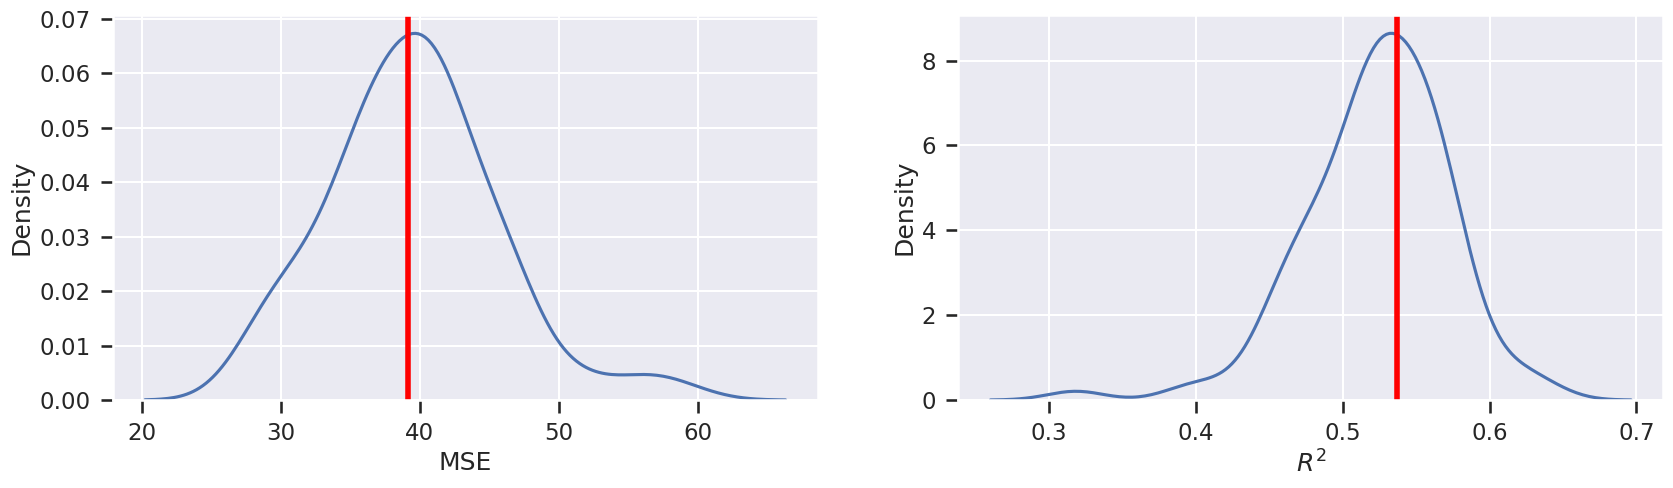

In [16]:
# run this cell
plt.figure(figsize = (20,5))

plt.subplot(121)
sns.kdeplot(MSE)
plt.axvline(x = MSE_loo, linewidth=4, color='r')
plt.xlabel("MSE")

plt.subplot(122)
sns.kdeplot(r2)
plt.axvline(x = r2_loo, linewidth=4, color='r')
plt.xlabel("$R^2$");

**Question 8 (3pts)** Where does the MSE and $R^2$ value from LOOCV sit relative to the distribution of values from the randomized training-testing approach? Does this result make sense to you given what you know about LOOCV? Why or why not? How might these graphs help you interpret the performance metrics you obtained in Question 3 to those in you obtained in Question 5?

*Your answer here*

*SOLUTION:* The MSE and $R^2$ values from LOOCV are at the peak distribution from randomized training-testing approach. There are a lot of possible responses that are correct, but students should answer all 3 questions
* where do LOOCV values sit relative
* does this help explain LOOCV
* how can they help you interpret performance metrics

### K-Fold Cross Validation with scikit-learn

We'll close by introducing how to implement k-fold cross validation using `scikit-learn`. Unlike LOOCV, k-fold cross validation uses a smaller number of folds than the number of observations in the dataset. 

**Question 9 (2pts)** Name one advantage and one disadvantage of k-fold cross validation relative to LOOCV.

*YOUR ANSWER HERE*

*SOLUTION:* Accept any response that includes on advantage and one disadvantage. 

Let's practice splitting training data into k-folds for validation purposes. First, we'll import the `KFold` module from `scikit-learn`. 

In [17]:
from sklearn.model_selection import KFold

Now we'll split the array `X` from Question 1 into 4 folds, shuffling before we add the batches, with a random state of 1. For each fold, we'll print the indices of the Train and Validation sets onto the console.

In [18]:
kf = KFold(n_splits = 4, shuffle = True, random_state = 1)

fold = 1
for t_index, v_index in kf.split(X):
    print("Fold", fold)
    print("Train:", t_index, "Test:", v_index, '\n')
    fold+=1

Fold 1
Train: [  0   1   2   3   7   8   9  10  12  13  14  15  16  19  20  21  22  23
  24  25  26  27  28  30  32  33  35  36  37  38  39  43  44  45  46  48
  49  50  51  52  53  54  55  56  57  59  60  61  63  64  68  69  70  71
  72  73  74  75  76  77  79  80  81  82  83  84  86  87  88  89  91  93
  94  95  96  97  98  99 100 103 104 105 106 108 109 111 112 113 114 115
 116 118 120 121 122 123 124 125 126 127 129 130 131 133 134 136 137 138
 139 140 141 142 143 144 145 148 149 150 151 152 153 154 155 156 157 158
 161 163 166 167 169 170 171 172 174 175 176 177 178 180 181 182 183 184
 186 187 188 190 191 193 194 195 196 197 198 199 200 202 203 205 206 207
 208 209 210 211 212 213 215 216 217 219 220 221 222 226 227 228 229 230
 231 234 235 236 237 238 239 240 241 243 244 246 247 248 249 250 251 252
 253 254 255 256 259 260 262 263 264 265 266 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 286 287 288 290 295 296 297 299 300
 301 302 303 304 305 308 309 310 313 

**Question 10 (3 pts):** Using the code above as a starting point: 
1. Separate the `X` and `y` data into testing and validation subsets for each fold. 
2. Train a linear regression model using the validation subset for each fold. 
3. Save the testing MSE associated with each fold to a list called `fold_mse`. 
4. Print the mean MSE from across all four folds. 

In [19]:
kf = KFold(n_splits = 4, shuffle = True, random_state = 1)

fold_mse = ... # initiate a list to hold the MSE associated with each fold

for t_index, v_index in kf.split(X):
    # Subset X and y into training and validation subsets
    X_fold_train = ...
    y_fold_train = ...
    X_fold_val = ...
    y_fold_val = ...
    
    # Initiate and fit a linear regression model using the training data
    lm = ...
    
    # Predict the Y-values associated with the validation data
    y_pred = ...
    
    # Find the testing MSE and append it to fold_mse
    ...
  
    
print(fold_mse)

# Find the mean MSE across all four folds
np.mean(fold_mse)

Ellipsis


TypeError: unsupported operand type(s) for /: 'ellipsis' and 'int'

In [20]:
#SOLUTION 
kf = KFold(n_splits = 4, shuffle = True, random_state = 1)

fold_mse = [] # initiate a list to hold the MSE associated with each fold

fold = 1
for t_index, v_index in kf.split(X):
    # Subset X and y into training and validation subsets
    X_fold_train = X.loc[t_index]
    y_fold_train = y.loc[t_index]
    X_fold_val = X.loc[v_index]
    y_fold_val = y.loc[v_index]
    
    # Initiate and fit a linear regression model using the training data
    lm = LinearRegression()
    lm.fit(X_fold_train, y_fold_train)
    
    # Predict the Y-values associated with the validation data
    y_pred = lm.predict(X_fold_val)
    
    # Find the testing MSE and append it to fold_mse
    fold_mse.append(np.mean((y_pred - y_fold_val)**2))
  
    fold+=1
    
print(fold_mse)

# Find the mean MSE across all four folds
np.mean(fold_mse)

[46.62638937792802, 38.50287465284151, 31.827689887664423, 41.81838007738461]


39.69383349895464

### Bibliography
- DS100 - “Gradient Descent” - https://www.textbook.ds100.org/ch/11/gradient_descent_define.html 
- DS100 - “Absolute Loss” - https://www.textbook.ds100.org/ch/10/modeling_abs_huber.html
- DS100 - “Models and Estimation” - http://www.ds100.org/fa18/assets/lectures/lec09/09-Models-and-Estimation-II.html 

---
Notebook developed by: Joshua Asuncion, Rebekah Tang

Data Science Modules: http://data.berkeley.edu/education/modules
